## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

# Import Library

In [ ]:
# =============================================================================
# PASO 1: IMPORTACIÓN DE LIBRERÍAS NECESARIAS
# =============================================================================
# En este primer paso importamos todas las herramientas que necesitaremos

# numpy: librería fundamental para computación científica en Python
# Nos permite trabajar con arrays multidimensionales de forma eficiente
import numpy as np

# pandas: herramienta para análisis y manipulación de datos estructurados
# Usaremos DataFrames para organizar los nombres de archivos y sus etiquetas
import pandas as pd 

# matplotlib.pyplot: librería de visualización para crear gráficos
# La usaremos para mostrar imágenes y gráficos de resultados
import matplotlib.pyplot as plt

# TensorFlow Keras: framework de deep learning de alto nivel
# ImageDataGenerator: clase para generar batches de datos con data augmentation en tiempo real
# load_img: función para cargar imágenes desde el disco
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# scikit-learn: librería de machine learning
# train_test_split: función para dividir datasets en conjuntos de entrenamiento y validación
from sklearn.model_selection import train_test_split

# random: módulo para generar números aleatorios y seleccionar muestras
import random

# os: módulo para interactuar con el sistema operativo
# Lo usaremos para navegar por carpetas y listar archivos
import os

# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [ ]:
# =============================================================================
# PASO 2: DEFINICIÓN DE CONSTANTES DEL PROYECTO
# =============================================================================
# Las constantes son valores que permanecerán fijos durante todo el experimento
# Definirlas al principio facilita modificar el código más adelante

# IMAGE_WIDTH e IMAGE_HEIGHT: dimensiones a las que redimensionaremos todas las imágenes
# Elegimos 64x64 píxeles como compromiso entre:
# - Mantener información visual suficiente para distinguir perros y gatos
# - Reducir el costo computacional y la memoria RAM necesaria
# NOTA: Imágenes más grandes = más detalles pero más lento el entrenamiento
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64

# IMAGE_CHANNELS: número de canales de color
# RGB (Red, Green, Blue) = 3 canales
# Esto significa que cada píxel tiene 3 valores numéricos (uno por color)
# Alternativa: usar 1 canal para escala de grises (blanco y negro)
IMAGE_CHANNELS = 3

# IMAGE_SIZE: tupla completa que define la forma de nuestras imágenes
# Formato: (ancho, alto, canales) = (64, 64, 3)
# Esta tupla será la forma de entrada (input shape) de nuestra red neuronal
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

# BATCH_SIZE: número de imágenes que procesaremos simultáneamente en cada iteración
# 128 imágenes por batch significa:
# - El modelo actualiza sus pesos después de procesar 128 imágenes
# - Batch más grande = entrenamiento más rápido pero necesita más memoria
# - Batch más pequeño = entrenamiento más lento pero más estable
BATCH_SIZE = 128

# EPOCHS: número de veces que el modelo verá el conjunto COMPLETO de datos
# En cada epoch, el modelo pasa por todas las imágenes de entrenamiento una vez
# 20 epochs significa que cada imagen será vista 20 veces durante el entrenamiento
# Más epochs = más aprendizaje, pero riesgo de overfitting (memorizar en vez de generalizar)
EPOCHS = 20

# Prepare Training Data
1. Descárgate el dataset
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador.
3. En este punto vamos guardar en una lista las etiquetas de cada foto.

In [ ]:
# =============================================================================
# PASO 3: CONFIGURACIÓN DE RUTAS DE ARCHIVOS
# =============================================================================
# Necesitamos indicar al programa dónde están ubicadas las imágenes

# ROOT_PATH: obtenemos el directorio actual donde se ejecuta este notebook
# os.getcwd() = "get current working directory" = obtener directorio de trabajo actual
ROOT_PATH = os.getcwd()

# TRAIN_PATH: ruta completa a la carpeta que contiene las imágenes de ENTRENAMIENTO
# Esta carpeta contiene aproximadamente 25,000 imágenes de perros y gatos
# Formato de nombres: cat.0.jpg, cat.1.jpg, dog.0.jpg, dog.1.jpg, etc.
# El nombre del archivo nos indica la categoría (cat o dog)
TRAIN_PATH = ROOT_PATH + "\\dogsandcats\\train\\"

# TEST_PATH: ruta completa a la carpeta que contiene las imágenes de PRUEBA (test)
# Estas imágenes NO se usan durante el entrenamiento
# Las reservamos para evaluar el rendimiento final del modelo
# Esto simula cómo funcionaría el modelo con datos completamente nuevos
TEST_PATH = ROOT_PATH + "\\dogsandcats\\test\\"

# NOTA IMPORTANTE: Antes de ejecutar este notebook, debes:
# 1. Descargar el dataset de Kaggle Dogs vs Cats
# 2. Descomprimir el archivo ZIP
# 3. Colocar las carpetas train y test dentro de una carpeta llamada "dogsandcats"

In [ ]:
# =============================================================================
# PASO 4: CREACIÓN DEL DATAFRAME CON NOMBRES DE ARCHIVOS Y ETIQUETAS
# =============================================================================
# Vamos a crear una tabla (DataFrame) que organice la información de nuestras imágenes

# Primero, listamos TODOS los archivos que hay en la carpeta de entrenamiento
# os.listdir() devuelve una lista con todos los nombres de archivo
# Ejemplo: ['cat.0.jpg', 'cat.1.jpg', 'dog.0.jpg', 'dog.1.jpg', ...]
filenames = os.listdir(TRAIN_PATH)

# Creamos una lista vacía donde guardaremos las etiquetas (labels) de cada imagen
# Las etiquetas nos dirán si cada imagen es un gato o un perro
categories = []

# Ahora iteramos (recorremos uno por uno) todos los nombres de archivo
for filename in filenames:
    # Extraemos la categoría del nombre del archivo
    # filename.split('.') divide el nombre por el punto '.'
    # Ejemplo: 'dog.123.jpg'.split('.') → ['dog', '123', 'jpg']
    # Tomamos el primer elemento [0] → 'dog' o 'cat'
    category = filename.split('.')[0]
    
    # Convertimos la categoría de texto a número:
    # - dog (perro) = 1 (clase positiva)
    # - cat (gato) = 0 (clase negativa)
    # ¿Por qué números? Porque las redes neuronales trabajan con números, no con texto
    if category == 'dog':
        categories.append(1)  # Añadimos 1 a la lista
    else:
        categories.append(0)  # Añadimos 0 a la lista

# Creamos un DataFrame de pandas para organizar la información en formato tabla
# Un DataFrame es como una hoja de Excel con filas y columnas
df = pd.DataFrame({
    'filename': filenames,    # Primera columna: nombre del archivo (ej: 'cat.123.jpg')
    'category': categories    # Segunda columna: etiqueta numérica (0 o 1)
})

# Resultado: una tabla con dos columnas y 25,000 filas (una por cada imagen)
# Esto nos permite manipular y acceder fácilmente a la información de nuestras imágenes

In [5]:
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
6571,dog.9995.jpg,1
6572,dog.9996.jpg,1
6573,dog.9997.jpg,1
6574,dog.9998.jpg,1


### See Total In count

In [ ]:
# =============================================================================
# PASO 5: VISUALIZACIÓN DE LA DISTRIBUCIÓN DE CLASES
# =============================================================================
# Es MUY IMPORTANTE verificar si nuestro dataset está balanceado
# Un dataset balanceado tiene aproximadamente el mismo número de ejemplos de cada clase

# value_counts() cuenta cuántos gatos (0) y cuántos perros (1) tenemos
# plot.bar() crea un gráfico de barras para visualizarlo
df['category'].value_counts().plot.bar()

# ¿Por qué es importante el balance?
# - Si tuviéramos 9000 gatos y 1000 perros, el modelo aprendería un sesgo
# - Podría predecir "gato" siempre y acertar el 90% sin aprender realmente
# - Un dataset balanceado (50%-50%) asegura que el modelo aprenda ambas clases por igual
# En nuestro caso, deberíamos ver dos barras de altura similar (aprox. 3288 de cada una)

# See sample image

In [ ]:
# =============================================================================
# PASO 6: EXPLORACIÓN DE UNA IMAGEN - ¿QUÉ ES UNA IMAGEN DIGITALMENTE?
# =============================================================================
# Vamos a cargar y visualizar una imagen para entender su estructura interna

# Importamos librerías para leer y manipular imágenes
from skimage.io import imread  # scikit-image para leer imágenes
import cv2  # OpenCV para procesamiento de imágenes

# Seleccionamos UNA imagen al azar del dataset
# random.choice() elige un elemento aleatorio de la lista
sample = random.choice(filenames)

# Leemos la imagen como un array (matriz) de numpy
# imread carga la imagen en formato RGB (Red, Green, Blue)
# La imagen se convierte en números que la computadora puede procesar
image = imread(TRAIN_PATH + sample)

# Mostramos las dimensiones de la imagen
# shape nos da: (altura_en_píxeles, ancho_en_píxeles, número_de_canales)
# Ejemplo: (375, 500, 3) = 375 píxeles de alto, 500 de ancho, 3 canales RGB
print("Dimensiones de la imagen (altura, ancho, canales):", image.shape)

# Mostramos el valor MÁXIMO de píxel
# Las imágenes digitales típicamente usan valores de 0 a 255 para cada canal
# 0 = negro/ausencia de color, 255 = máxima intensidad de color
print("Valor máximo de píxel:", np.max(image))

# Visualizamos la imagen
# matplotlib.pyplot interpreta el array de números y lo renderiza como imagen
plt.imshow(image)

# CONCEPTO CLAVE: Una imagen NO es más que una tabla de números
# Cada píxel tiene 3 valores (R, G, B) que definen su color
# La red neuronal aprenderá patrones en estos números para distinguir perros y gatos

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [8]:
image

array([[[ 91,  82,  75],
        [ 88,  79,  72],
        [ 86,  77,  70],
        ...,
        [164, 139,  98],
        [164, 139,  98],
        [165, 136,  96]],

       [[ 79,  70,  63],
        [ 79,  70,  63],
        [ 79,  70,  63],
        ...,
        [164, 139,  98],
        [164, 139,  98],
        [166, 137,  97]],

       [[ 77,  68,  61],
        [ 79,  70,  63],
        [ 82,  73,  66],
        ...,
        [164, 139,  98],
        [164, 139,  98],
        [167, 138,  98]],

       ...,

       [[ 19,  11,   9],
        [ 19,  11,   9],
        [ 18,  10,   8],
        ...,
        [ 59,  44,  41],
        [ 52,  37,  32],
        [ 49,  30,  24]],

       [[ 19,  11,   9],
        [ 19,  11,   9],
        [ 18,  10,   8],
        ...,
        [ 59,  44,  41],
        [ 50,  35,  30],
        [ 48,  29,  23]],

       [[ 19,  11,   9],
        [ 19,  11,   9],
        [ 18,  10,   8],
        ...,
        [ 59,  44,  41],
        [ 49,  34,  29],
        [ 48,  29,  23]]

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

In [ ]:
# =============================================================================
# PASO 7: REDIMENSIONAMIENTO (RESIZE) DE IMÁGENES
# =============================================================================
# PROBLEMA: Las imágenes tienen diferentes tamaños (ej: 500x375, 800x600, etc.)
# SOLUCIÓN: Redimensionar TODAS las imágenes a un tamaño fijo (64x64)

# ¿Por qué redimensionar?
# 1. Las redes neuronales necesitan inputs del MISMO tamaño
# 2. Reducir el tamaño ahorra MUCHA memoria RAM (500MB → mucho menos)
# 3. El entrenamiento es más rápido con imágenes pequeñas

# Creamos una figura grande para mostrar la comparación
plt.figure(figsize=(12, 12))

# Seleccionamos una imagen aleatoria
sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

# REDIMENSIONAMOS la imagen usando OpenCV
# cv2.resize(imagen, (nuevo_ancho, nuevo_alto))
# Importante: OpenCV usa formato (ancho, alto), no (alto, ancho)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)

# Mostramos ambas imágenes lado a lado para comparar
# Subplot(filas, columnas, posición)

# Imagen ORIGINAL (izquierda)
plt.subplot(1, 2, 1)
plt.imshow(image)

# Imagen REDIMENSIONADA (derecha)
plt.subplot(1, 2, 2)
plt.imshow(imagesmall)

# OBSERVACIÓN: La imagen pequeña se ve más pixelada, pero aún podemos
# distinguir si es un perro o un gato. La red neuronal también podrá hacerlo.

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

In [ ]:
# =============================================================================
# PASO 8: EXPLORACIÓN DE IMÁGENES EN ESCALA DE GRISES (OPCIONAL)
# =============================================================================
# Alternativa: Podríamos usar BLANCO Y NEGRO en vez de color

# Seleccionamos una nueva imagen aleatoria
sample = random.choice(filenames)

# cv2.IMREAD_GRAYSCALE convierte la imagen a UN SOLO CANAL
# En lugar de RGB (3 canales), tenemos un solo valor por píxel (intensidad de gris)
# 0 = negro, 255 = blanco, valores intermedios = tonos de gris
image = cv2.imread(filename = TRAIN_PATH + sample, flags = cv2.IMREAD_GRAYSCALE)

# Mostramos las dimensiones de la imagen
# Solo 2 dimensiones (altura, ancho) porque solo hay 1 canal
print("Dimensiones:", image.shape)

# VENTAJAS de escala de grises:
# - Reduce memoria y procesamiento a 1/3 (1 canal vs 3 canales)
# - Entrenamiento más rápido

# DESVENTAJAS:
# - Perdemos información de color (que podría ser útil)
# - Algunos perros y gatos se distinguen por color del pelaje

# Visualizamos la imagen en escala de grises
# cmap='gray' le dice a matplotlib que use un mapa de colores de grises
plt.imshow(image, cmap='gray')

# DECISIÓN: Para este proyecto usaremos COLOR (RGB) porque tenemos suficiente
# capacidad computacional y el color puede ayudar a distinguir mejor

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [ ]:
# =============================================================================
# PASO 9: FUNCIÓN PARA CARGAR TODAS LAS IMÁGENES EN MEMORIA
# =============================================================================
# Esta es una de las partes más importantes y pesadas del preprocesamiento

def read_data(path, im_size):
    """
    Función que lee todas las imágenes de una carpeta y las convierte en arrays numpy
    
    Parámetros:
    - path: ruta de la carpeta que contiene las imágenes
    - im_size: tamaño al que redimensionar las imágenes (64 en nuestro caso)
    
    Retorna:
    - X: array numpy con todas las imágenes (forma: [n_imágenes, alto, ancho, canales])
    - Y: array numpy con todas las etiquetas (forma: [n_imágenes,])
    """
    
    # Creamos dos listas vacías:
    # X almacenará las IMÁGENES (features/características)
    # Y almacenará las ETIQUETAS (labels/objetivos)
    X = []
    Y = []
    
    # Iteramos sobre CADA archivo en la carpeta
    for file in os.listdir(path):
        
        # Leemos la imagen en COLOR (modo RGB con 3 canales)
        image = imread(path + file)
        
        # REDIMENSIONAMOS la imagen al tamaño especificado (64x64)
        # Esto asegura que todas las imágenes tengan el mismo tamaño
        smallimage = cv2.resize(image, (im_size, im_size))
        
        # Añadimos la imagen redimensionada a nuestra lista X
        X.append(smallimage)
        
        # Extraemos la ETIQUETA del nombre del archivo
        # Ejemplo: "dog.123.jpg" → ["dog", "123", "jpg"] → "dog"
        category = file.split('.')[0]
        
        # Convertimos la etiqueta a valor numérico
        # dog = 1, cat = 0
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)
    
    # CONVERTIMOS las listas a arrays de numpy
    # Esto es más eficiente para operaciones matemáticas y entrenamiento
    # X será un array 4D: (número_imágenes, altura, ancho, canales)
    # Y será un array 1D: (número_imágenes,)
    return np.array(X), np.array(Y)

# Cargamos los datos de ENTRENAMIENTO
# NOTA: Este proceso puede tardar varios minutos
X_train, y_train = read_data(TRAIN_PATH, IMAGE_WIDTH)

# Cargamos los datos de PRUEBA (test)
X_test, y_test = read_data(TEST_PATH, IMAGE_WIDTH)

# Mostramos las dimensiones de los arrays resultantes
# X_train: (6576, 64, 64, 3) → 6576 imágenes de 64x64 con 3 canales
# X_test: (3456, 64, 64, 3) → 3456 imágenes de prueba
print(X_train.shape)
print(X_test.shape)

In [ ]:
# Verificamos que las imágenes se han cargado correctamente
# Mostramos la dimensión de una imagen individual (debe ser 64x64x3)
print(X_train[1].shape)

# Visualizamos la segunda imagen del conjunto de entrenamiento
# Los valores están en escala 0-255 (sin normalizar aún)
plt.imshow(X_train[1])

In [13]:
X_train[0]

array([[[206, 167,  90],
        [212, 173,  96],
        [222, 179, 101],
        ...,
        [248, 215, 138],
        [247, 209, 128],
        [243, 204, 122]],

       [[206, 167,  90],
        [212, 173,  96],
        [222, 179, 101],
        ...,
        [247, 218, 142],
        [247, 212, 134],
        [244, 206, 126]],

       [[206, 167,  90],
        [212, 173,  96],
        [222, 179, 101],
        ...,
        [247, 217, 145],
        [247, 216, 141],
        [247, 209, 131]],

       ...,

       [[162, 128,  57],
        [166, 132,  61],
        [171, 134,  63],
        ...,
        [  3,   4,   0],
        [  3,   4,   0],
        [  2,   3,   0]],

       [[160, 125,  54],
        [162, 128,  57],
        [167, 130,  59],
        ...,
        [  3,   4,   0],
        [  3,   4,   0],
        [  2,   3,   0]],

       [[154, 123,  56],
        [158, 128,  60],
        [164, 130,  58],
        ...,
        [  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0]]

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [ ]:
# =============================================================================
# PASO 10: VERIFICACIÓN DEL RANGO DE VALORES ANTES DE NORMALIZAR
# =============================================================================
# Antes de entrenar, necesitamos verificar en qué rango están nuestros datos

# Las imágenes digitales almacenan cada píxel con valores entre 0 y 255
# - 0 representa la ausencia total de color (negro)
# - 255 representa la máxima intensidad de color (blanco o color puro)
# - Valores intermedios representan tonos entre negro y el color
print("Min:", np.min(X_train))  # Debería ser 0
print("Max:", np.max(X_train))  # Debería ser 255

In [ ]:
# =============================================================================
# PASO 11: NORMALIZACIÓN DE LOS DATOS - ¡MUY IMPORTANTE!
# =============================================================================
# La normalización es un paso CRÍTICO que mejora significativamente el entrenamiento

# Dividimos TODOS los valores entre 255 para convertir el rango [0, 255] a [0.0, 1.0]
# Esta es una operación vectorizada de numpy (muy rápida y eficiente)
X_train = X_train / 255.0
X_test = X_test / 255.0

# ¿POR QUÉ NORMALIZAR? Razones fundamentales:
# 
# 1. CONVERGENCIA MÁS RÁPIDA:
#    - Las redes neuronales aprenden mejor con valores pequeños
#    - Valores entre 0-1 facilitan el ajuste de pesos
#
# 2. ESTABILIDAD NUMÉRICA:
#    - Evita problemas de gradientes explosivos o que desaparecen
#    - Reduce errores de precisión numérica en los cálculos
#
# 3. UNIFORMIDAD DE ESCALA:
#    - Todas las features están en la misma escala
#    - Ninguna feature domina sobre otras por tener valores más grandes
#
# 4. MEJOR FUNCIONAMIENTO DE ACTIVACIONES:
#    - Funciones como sigmoid y tanh funcionan mejor en este rango
#    - ReLU también se beneficia de valores normalizados

# Verificamos que la normalización funcionó correctamente
print("Min:", np.min(X_train))  # Ahora es 0.0
print("Max:", np.max(X_train))  # Ahora es 1.0

# Shuffle data
Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [ ]:
# =============================================================================
# PASO 12: MEZCLADO ALEATORIO DE LOS DATOS (SHUFFLE)
# =============================================================================
# PROBLEMA: Los datos están ordenados (primero todos los gatos, luego todos los perros)
# SOLUCIÓN: Mezclarlos aleatoriamente

from sklearn.utils import shuffle

# shuffle() mezcla X_train e y_train MANTENIENDO LA CORRESPONDENCIA
# Es decir, cada imagen sigue emparejada con su etiqueta correcta
# random_state=42 asegura REPRODUCIBILIDAD (siempre la misma mezcla aleatoria)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# ¿POR QUÉ MEZCLAR? Razones importantes:
#
# 1. EVITAR SESGO EN ENTRENAMIENTO:
#    - Si entrenamos primero con gatos y luego con perros, el modelo aprende mal
#    - Necesita ver ejemplos mezclados para generalizar correctamente
#
# 2. DIVISIÓN TRAIN/VALIDATION BALANCEADA:
#    - Si dividimos datos ordenados 80/20, podríamos terminar con:
#      * Train: solo gatos
#      * Validation: solo perros
#    - Mezclando aseguramos distribución equilibrada
#
# 3. BATCHES REPRESENTATIVOS:
#    - Cada batch durante el entrenamiento contiene gatos Y perros
#    - Evita que el modelo se "olvide" de una clase mientras aprende la otra
#
# 4. REDUCIR VARIANZA:
#    - El orden de los datos no debe influir en el resultado
#    - Mezclar elimina patrones espurios relacionados con el orden

In [17]:
X_train

array([[[[0.06666667, 0.10196078, 0.08235294],
         [0.01568627, 0.02352941, 0.01176471],
         [0.23529412, 0.2745098 , 0.27843137],
         ...,
         [0.07058824, 0.10980392, 0.10588235],
         [0.0745098 , 0.11372549, 0.10980392],
         [0.07058824, 0.10980392, 0.10588235]],

        [[0.07058824, 0.10588235, 0.08627451],
         [0.02352941, 0.03137255, 0.01960784],
         [0.25098039, 0.27058824, 0.28235294],
         ...,
         [0.09803922, 0.1372549 , 0.13333333],
         [0.09411765, 0.13333333, 0.12941176],
         [0.09411765, 0.13333333, 0.12941176]],

        [[0.08627451, 0.12156863, 0.10196078],
         [0.03137255, 0.03921569, 0.02745098],
         [0.25490196, 0.27058824, 0.28235294],
         ...,
         [0.11372549, 0.15294118, 0.14901961],
         [0.10980392, 0.14901961, 0.14509804],
         [0.10980392, 0.14901961, 0.14509804]],

        ...,

        [[0.08235294, 0.08627451, 0.06666667],
         [0.08627451, 0.09019608, 0.07058824]

# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [ ]:
# =============================================================================
# PASO 13: GUARDAR LOS DATOS PROCESADOS EN ARCHIVO .npz
# =============================================================================
# Después de todo el trabajo de preprocesamiento, guardamos los resultados

# np.savez() guarda múltiples arrays de numpy en un archivo comprimido .npz
# Ventajas:
# - No hay que repetir el preprocesamiento cada vez
# - Cargar .npz es 100x más rápido que procesar 25,000 imágenes
# - Ahorramos tiempo en futuras ejecuciones del notebook
# - Los datos ya están normalizados y mezclados
np.savez(ROOT_PATH + '/data.npz',
        X_train = X_train,  # Imágenes de entrenamiento (normalizadas y mezcladas)
        y_train = y_train,  # Etiquetas de entrenamiento
        X_test = X_test,    # Imágenes de prueba (normalizadas)
        y_test = y_test)    # Etiquetas de prueba

Para cargar

In [ ]:
# =============================================================================
# PASO 14: CARGAR DATOS DESDE EL ARCHIVO .npz (ALTERNATIVA RÁPIDA)
# =============================================================================
# En futuras ejecuciones, podemos saltar TODO el preprocesamiento y cargar directamente

# np.load() carga el archivo .npz que creamos anteriormente
# Esto es MUCHO más rápido que volver a procesar todas las imágenes
data = np.load(ROOT_PATH + '/data.npz')

# Extraemos cada array usando las claves que definimos al guardar
X_train = data['X_train']  # Imágenes de entrenamiento (ya normalizadas y mezcladas)
X_test = data['X_test']    # Imágenes de prueba (ya normalizadas)
y_train = data['y_train']  # Etiquetas de entrenamiento
y_test = data['y_test']    # Etiquetas de prueba

# NOTA: Solo necesitas ejecutar las celdas anteriores (preprocesamiento) UNA VEZ
# Después, puedes empezar desde aquí cada vez que abras el notebook

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario. O 

In [20]:
IMAGE_SIZE

(64, 64, 3)

In [ ]:
# =============================================================================
# PASO 15: CONSTRUCCIÓN DE LA RED NEURONAL CONVOLUCIONAL (CNN)
# =============================================================================
# Esta es la ARQUITECTURA del modelo - el "cerebro" que aprenderá a distinguir gatos y perros

from tensorflow import keras

# Las CNNs (Redes Neuronales Convolucionales) son ideales para imágenes porque:
# - Detectan patrones visuales jerárquicos (bordes → texturas → formas → objetos)
# - Son invariantes a la posición (detectan un ojo sin importar dónde esté en la imagen)
# - Tienen menos parámetros que redes densas (más eficientes)

# Definimos las capas de la red en una lista, que se procesarán en ORDEN SECUENCIAL

layers = [
    # =========================================================================
    # BLOQUE CONVOLUCIONAL 1: Detección de características básicas
    # =========================================================================
    # Conv2D(128, (3,3)): Primera capa convolucional
    #   - 128 filtros: aprenderá 128 detectores de patrones diferentes
    #   - (3,3): cada filtro es una ventana de 3x3 píxeles
    #   - Detectará features básicas: bordes horizontales, verticales, diagonales, texturas
    # activation='relu': función de activación ReLU (Rectified Linear Unit)
    #   - Introduce no-linealidad (permite aprender patrones complejos)
    #   - ReLU(x) = max(0, x) → elimina valores negativos
    # input_shape=IMAGE_SIZE: especifica dimensiones de entrada (64, 64, 3)
    #   - Solo necesario en la PRIMERA capa
    keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=IMAGE_SIZE),
    
    # MaxPooling2D(2,2): Primera capa de reducción de dimensionalidad
    #   - Reduce el tamaño a la mitad tomando el valor MÁXIMO de cada ventana 2x2
    #   - Input: 62x62 → Output: 31x31
    #   - Beneficios: reduce memoria, previene overfitting, detecta features invariantes a escala
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # =========================================================================
    # BLOQUE CONVOLUCIONAL 2: Características de nivel medio
    # =========================================================================
    # Conv2D(64, (3,3)): Segunda capa convolucional
    #   - 64 filtros (menos que antes porque la imagen ya es más pequeña)
    #   - Detecta features más complejas: combinaciones de bordes, texturas avanzadas
    #   - Aprende partes de objetos: esquinas, patrones de pelo, formas geométricas
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    
    # Segunda reducción: 29x29 → 14x14
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # =========================================================================
    # BLOQUE CONVOLUCIONAL 3: Características de alto nivel
    # =========================================================================
    # Conv2D(64, (3,3)): Tercera capa convolucional
    #   - Detecta features muy abstractas y específicas
    #   - Ejemplos: orejas de gato, hocico de perro, patrones de pelaje, ojos
    #   - Combina todas las features anteriores para formar conceptos complejos
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    
    # Tercera reducción: 12x12 → 6x6
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # =========================================================================
    # TRANSICIÓN: De capas convolucionales a capas densas
    # =========================================================================
    # Flatten(): Aplana el tensor 3D en un vector 1D
    #   - Input: tensor de forma (6, 6, 64)
    #   - Output: vector de forma (2304,) → 6 × 6 × 64 = 2304 valores
    #   - Necesario para conectar con las capas densas (fully connected)
    keras.layers.Flatten(),
    
    # =========================================================================
    # CAPAS DENSAS (Fully Connected): Clasificación final
    # =========================================================================
    # Estas capas toman todas las features extraídas y aprenden a combinarlas
    # para tomar la decisión final: ¿es un gato o un perro?
    
    # Dense(64, activation='relu'): Primera capa densa
    #   - 64 neuronas totalmente conectadas
    #   - Aprende combinaciones complejas de todas las features
    keras.layers.Dense(64, activation='relu'),
    
    # Dense(16, activation='relu'): Segunda capa densa
    #   - 16 neuronas - va reduciendo dimensionalidad
    #   - Refina la clasificación
    keras.layers.Dense(16, activation='relu'),
    
    # =========================================================================
    # CAPA DE SALIDA: La predicción final
    # =========================================================================
    # Dense(1, activation='sigmoid'): Neurona de salida
    #   - 1 sola neurona para clasificación binaria (gato vs perro)
    #   - sigmoid: aplasta el valor a un rango entre 0 y 1
    #     * sigmoid(x) = 1 / (1 + e^(-x))
    #     * Output cercano a 0 → el modelo predice GATO
    #     * Output cercano a 1 → el modelo predice PERRO
    #     * Podemos interpretar el output como "probabilidad de ser perro"
    keras.layers.Dense(1, activation='sigmoid')
]

# =============================================================================
# CREAR Y COMPILAR EL MODELO
# =============================================================================

# Sequential: las capas se ejecutan en ORDEN, una después de otra
model = keras.Sequential(layers)

# COMPILACIÓN: configuramos cómo aprenderá el modelo
model.compile(
    # optimizer='adam': Algoritmo de optimización Adam
    #   - Ajusta los pesos de la red para minimizar el error
    #   - Adam es muy popular porque:
    #     * Aprende rápido
    #     * Es robusto (funciona bien sin mucho ajuste)
    #     * Adapta la tasa de aprendizaje automáticamente
    optimizer = 'adam',
    
    # loss='binary_crossentropy': Función de pérdida para clasificación binaria
    #   - Mide qué tan "equivocado" está el modelo
    #   - Valores bajos = predicciones buenas
    #   - Valores altos = predicciones malas
    #   - El optimizador intentará MINIMIZAR esta pérdida
    loss = 'binary_crossentropy',
    
    # metrics=['accuracy']: Métricas a monitorear
    #   - Accuracy = porcentaje de predicciones correctas
    #   - Más fácil de interpretar que el loss
    #   - Ejemplo: accuracy=0.85 significa 85% de aciertos
    metrics = ['accuracy']
)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,881 (1.00 MB)

 Trainable params: 262,881 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# CÁLCULO DE PARÁMETROS - Primera capa convolucional
# Cada filtro 3x3 tiene 9 pesos por cada canal de entrada (3 canales RGB)
# 128 filtros × (3×3×3 pesos + 1 bias) = 128 × 28 = 3584 parámetros
128*(3*3)*3 + 128

3584

In [24]:
# CÁLCULO DE PARÁMETROS - Segunda capa convolucional
# 64 filtros × (3×3×128 canales de entrada + 1 bias) = 73792 parámetros
64*(3*3)*128 + 64

73792

In [25]:
# CÁLCULO DE PARÁMETROS - Tercera capa convolucional
# 64 filtros × (3×3×64 canales + 1 bias) = 36928 parámetros
64*(3*3)*64 + 64

36928

In [26]:
# CÁLCULO DEL TAMAÑO después de Flatten
# Después de 3 MaxPooling(2,2), la imagen 64x64 se redujo a 6x6
# Con 64 canales: 6 × 6 × 64 = 2304 valores aplanados
6*6*64

2304

In [27]:
# CÁLCULO DE PARÁMETROS - Primera capa densa
# 2304 entradas × 64 neuronas + 64 bias = 147520 parámetros
# Esta es la capa con más parámetros del modelo
2304 * 64 + 64

147520

In [28]:
# CÁLCULO DE PARÁMETROS - Segunda capa densa
# 64 entradas × 16 neuronas + 16 bias = 1040 parámetros
64 * 16 + 16

1040

# Callbacks
#### Early Stopping

In [ ]:
# =============================================================================
# PASO 16: CALLBACKS - EARLY STOPPING
# =============================================================================
# Los callbacks son funciones que se ejecutan DURANTE el entrenamiento
# Nos permiten controlar y automatizar el proceso de aprendizaje

from keras.callbacks import EarlyStopping

# EarlyStopping: Detiene el entrenamiento automáticamente cuando deja de mejorar
# patience=5: Esperará 5 epochs SIN mejora antes de detener
#   - Ejemplo:
#     * Epoch 1: val_loss = 0.50
#     * Epoch 2: val_loss = 0.48 (mejora, contador = 0)
#     * Epoch 3: val_loss = 0.49 (empeora, contador = 1)
#     * Epoch 4: val_loss = 0.50 (empeora, contador = 2)
#     * ... si llega a contador = 5, se detiene
# 
# BENEFICIOS:
# - Previene OVERFITTING (memorizar en vez de aprender)
# - Ahorra TIEMPO (no entrena epochs innecesarios)
# - Encuentra el punto óptimo automáticamente
earlystop = EarlyStopping(patience=5)

In [ ]:
# =============================================================================
# PASO 17: CALLBACKS - MODEL CHECKPOINT
# =============================================================================
# ModelCheckpoint guarda el modelo automáticamente durante el entrenamiento

from keras.callbacks import ModelCheckpoint

# Guardará el modelo cada vez que mejore el val_loss
# "callback_model.keras": nombre del archivo donde se guardará
#
# BENEFICIOS:
# - Guarda automáticamente el MEJOR modelo
# - No perdemos progreso si el entrenamiento falla
# - Podemos recuperar el mejor modelo aunque continúe entrenando
#
# NOTA IMPORTANTE: El mejor modelo puede NO ser el del último epoch
# Si el modelo empieza a hacer overfitting, los últimos epochs empeoran
# ModelCheckpoint nos asegura tener siempre la mejor versión guardada
mcheckpoint = ModelCheckpoint("callback_model.keras")

# Fit the model

In [ ]:
# =============================================================================
# PASO 18: ¡ENTRENAR EL MODELO! - Aquí sucede la MAGIA del Deep Learning
# =============================================================================
# Este es el momento donde el modelo APRENDE a distinguir gatos de perros

# model.fit() es el método que ENTRENA la red neuronal
history = model.fit(
    # X_train: imágenes de entrenamiento (features)
    # y_train: etiquetas de entrenamiento (targets)
    X_train,
    y_train,
    
    # epochs=EPOCHS: número de veces que verá TODO el dataset (20 veces)
    # En cada epoch:
    #   1. El modelo ve TODAS las imágenes de entrenamiento
    #   2. Ajusta sus pesos para reducir el error
    #   3. Evalúa su rendimiento en el conjunto de validación
    epochs = EPOCHS,
    
    # batch_size=BATCH_SIZE: procesa 128 imágenes a la vez
    # ¿Cómo funciona?
    #   - Divide 6576 imágenes en batches de 128
    #   - Procesa un batch → calcula error → actualiza pesos
    #   - Repite para todos los batches = 1 epoch completo
    batch_size = BATCH_SIZE,
    
    # callbacks: funciones que se ejecutan durante el entrenamiento
    # - earlystop: detiene si no hay mejora
    # - mcheckpoint: guarda el mejor modelo
    callbacks = [earlystop, mcheckpoint],
    
    # validation_split=0.2: Usa el 20% de datos para VALIDACIÓN
    # División automática:
    #   - 80% (5260 imágenes) → entrenamiento
    #   - 20% (1316 imágenes) → validación
    # La validación NO se usa para entrenar, solo para evaluar
    # Nos ayuda a detectar OVERFITTING durante el entrenamiento
    validation_split = 0.2
)

# El objeto 'history' contiene TODO el historial del entrenamiento:
# - history.history['loss']: pérdida en training por epoch
# - history.history['val_loss']: pérdida en validation por epoch
# - history.history['accuracy']: precisión en training por epoch
# - history.history['val_accuracy']: precisión en validation por epoch

# Evaluate
Probemos los datos en el conjunto de test.

In [ ]:
# =============================================================================
# PASO 19: EVALUACIÓN DEL MODELO EN EL CONJUNTO DE TEST
# =============================================================================
# Es CRUCIAL evaluar en datos que el modelo NUNCA ha visto

# ¿Por qué usar un conjunto de TEST separado?
# - Durante el entrenamiento, el modelo vio X_train
# - Durante la validación, el modelo vio parte de X_train
# - X_test es COMPLETAMENTE NUEVO para el modelo
# - Esto simula cómo funcionará el modelo en producción (con datos reales nuevos)

# model.evaluate() calcula el loss y las métricas en un conjunto de datos
results = model.evaluate(X_test, y_test)

# results contiene: [loss, accuracy]
# - loss: qué tan equivocado está el modelo (más bajo = mejor)
# - accuracy: porcentaje de predicciones correctas

# Interpretación de resultados:
# - Accuracy > 90%: Excelente modelo
# - Accuracy 80-90%: Muy buen modelo
# - Accuracy 70-80%: Buen modelo
# - Accuracy < 70%: Modelo necesita mejoras
#
# IMPORTANTE: Comparar con validation accuracy
# - Si test accuracy ≈ validation accuracy → modelo generaliza bien
# - Si test accuracy << validation accuracy → overfitting

In [33]:
# HACER PREDICCIONES en el conjunto de test
# model.predict() devuelve probabilidades entre 0 y 1
# .round(0) redondea: valores < 0.5 -> 0 (gato), valores >= 0.5 -> 1 (perro)
model.predict(X_test).round(0)

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]], shape=(3456, 1), dtype=float32)

In [ ]:
# =============================================================================
# PASO 20: MATRIZ DE CONFUSIÓN - Análisis Detallado de Errores
# =============================================================================
# La matriz de confusión es una herramienta FUNDAMENTAL para entender el rendimiento

from sklearn.metrics import confusion_matrix

# Generamos predicciones para todo el conjunto de test
# .predict() devuelve probabilidades entre 0 y 1
# .round(0) redondea: <0.5 → 0 (gato), ≥0.5 → 1 (perro)

# Calculamos la matriz de confusión
# Estructura de la matriz:
#                    Predicho
#                 Gato (0)  Perro (1)
#      ┌─────────────────────────────┐
# Real │   TN          FP        │ Gato (0)
#      │   (Verdaderos  (Falsos     │
#      │   Negativos)   Positivos)  │
#      │                             │
#      │   FN          TP        │ Perro (1)
#      │   (Falsos      (Verdaderos │
#      │   Negativos)   Positivos)  │
#      └─────────────────────────────┘
#
# TN (True Negatives): gatos correctamente clasificados como gatos
# FP (False Positives): gatos incorrectamente clasificados como perros (Error tipo I)
# FN (False Negatives): perros incorrectamente clasificados como gatos (Error tipo II)
# TP (True Positives): perros correctamente clasificados como perros
#
# ¿Cómo interpretar?
# - TN + TP = predicciones CORRECTAS
# - FP + FN = predicciones INCORRECTAS
# - Si FP > FN: el modelo confunde más gatos como perros
# - Si FN > FP: el modelo confunde más perros como gatos
confusion_matrix(y_test, model.predict(X_test).round(0))

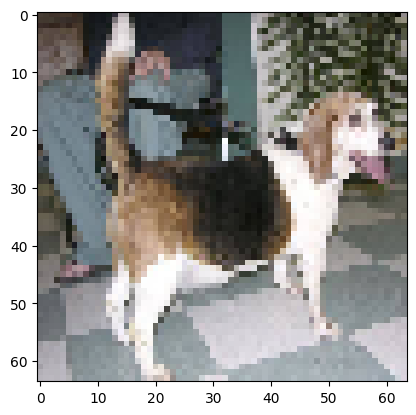

In [35]:
# Visualizamos una de las imágenes de test para ver qué estamos clasificando
plt.imshow(X_test[-3]);

In [36]:
# Hacemos una predicción individual para una imagen específica
# El modelo devuelve la probabilidad de que sea un perro
# 0.276 significa ~28% probabilidad de perro -> se clasifica como gato
predictions = model.predict(X_test[-4:-3])
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


array([[0.6917343]], dtype=float32)

# Image data generator

In [ ]:
# =============================================================================
# PREPARACIÓN PARA DATA AUGMENTATION
# =============================================================================
# Convertimos las etiquetas numéricas de vuelta a texto para ImageDataGenerator

# ImageDataGenerator de Keras requiere etiquetas de TEXTO, no numéricas
# Entonces necesitamos convertir: 0 → 'cat', 1 → 'dog'
# replace() hace esta conversión en todo el DataFrame
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

In [ ]:
# Importamos el generador de datos y la función para cargar imágenes desde TensorFlow Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# Seleccionamos 1 imagen aleatoria del DataFrame original (df) para demostrar el data augmentation
example_df = df.sample(n=1).reset_index(drop=True)

# Creamos un generador de datos con varias transformaciones para aumentar el dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normaliza píxeles a valores entre 0 y 1
    rotation_range=15,       # Rota la imagen aleatoriamente hasta 15 grados
    shear_range=0.1,         # Aplica una transformación de cizallamiento
    zoom_range=0.2,          # Hace zoom aleatorio (ampliar o reducir) hasta un 20%
    horizontal_flip=True,    # Voltea horizontalmente la imagen
    width_shift_range=0.1,   # Desplaza horizontalmente hasta un 10% del ancho
    height_shift_range=0.1   # Desplaza verticalmente hasta un 10% de la altura
)

# Creamos un generador que tomará la imagen seleccionada desde el DataFrame
example_generator = train_datagen.flow_from_dataframe(
    example_df,              # DataFrame que contiene 1 sola imagen
    TRAIN_PATH,              # Carpeta donde están almacenadas las imágenes reales
    x_col='filename',        # Nombre de la columna que contiene los nombres de archivo
    y_col='category',        # Columna con la etiqueta de la imagen
    target_size=(128, 128)   # Redimensiona la imagen a 128x128 píxeles
)


Found 1 validated image filenames belonging to 1 classes.


In [40]:
example_df

,filename,category
0,cat.1787.jpg,cat


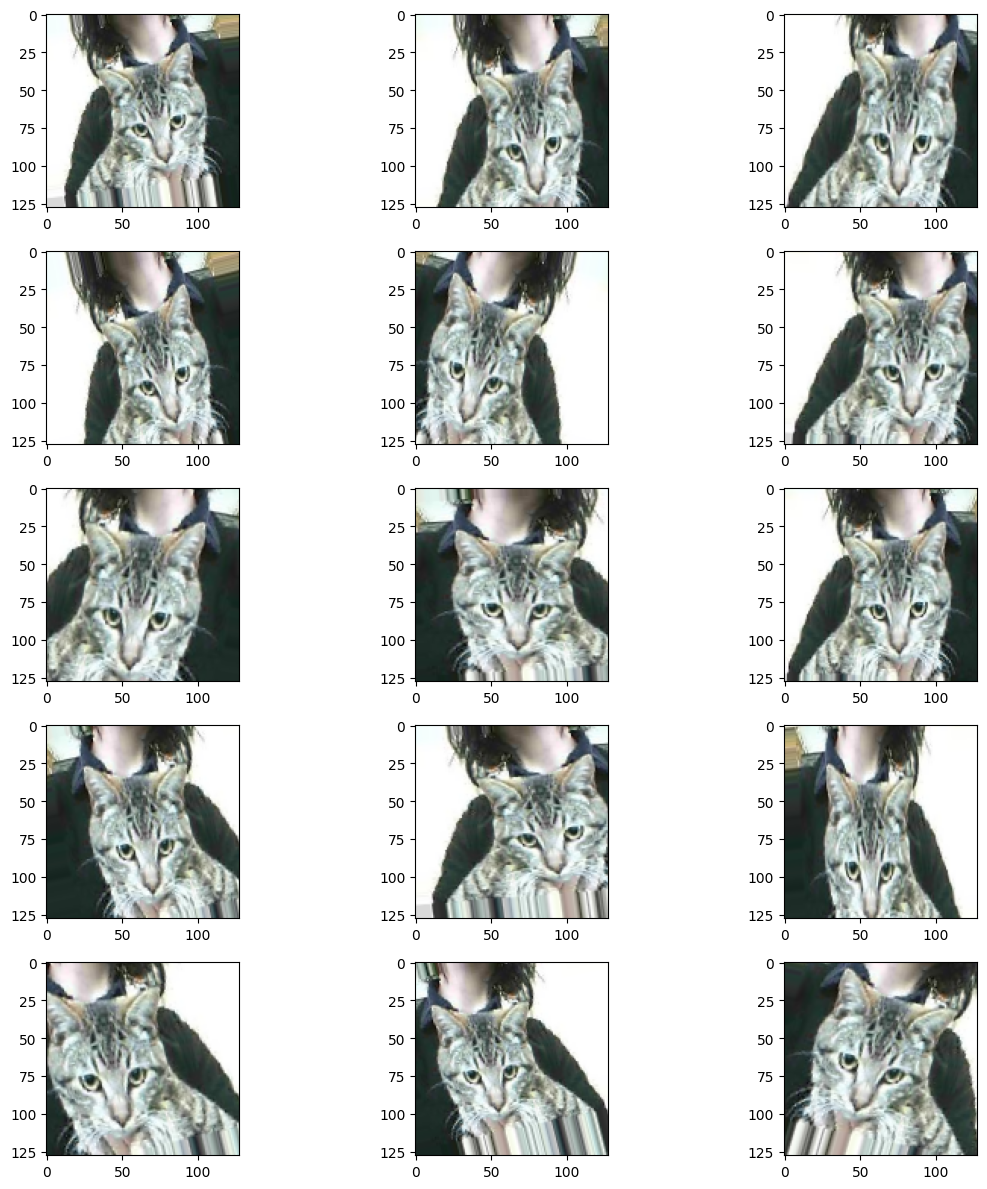

In [41]:
# Visualizamos 15 VARIACIONES de la misma imagen
# Cada iteración genera una versión diferente aplicando transformaciones aleatorias
# Nota cómo el perro/gato aparece rotado, desplazado, con zoom, etc.
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    # Generamos una versión transformada de la imagen
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break  # Solo queremos una imagen por iteración
plt.tight_layout()
plt.show()

# Training Generator

In [42]:
# Dividimos el DataFrame en ENTRENAMIENTO (80%) y VALIDACIÓN (20%)
# Esto es diferente al test set - la validación se usa durante el entrenamiento
train_df, validate_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42)

# Reseteamos los índices para evitar problemas
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [43]:
# Verificamos el tamaño de cada conjunto
total_train = train_df.shape[0]       # 5260 imágenes para entrenar
total_validate = validate_df.shape[0] # 1316 imágenes para validar

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 5260
Shape validation 1316


,filename,category
0,cat.1419.jpg,cat
1,dog.10421.jpg,dog
2,cat.2146.jpg,cat
3,dog.11562.jpg,dog
4,cat.3654.jpg,cat


In [44]:
train_df.head()

,filename,category
0,cat.3337.jpg,cat
1,dog.12039.jpg,dog
2,cat.2542.jpg,cat
3,dog.10283.jpg,dog
4,dog.10384.jpg,dog


In [ ]:
# =============================================================================
# PASO 22: GENERADOR DE ENTRENAMIENTO CON DATA AUGMENTATION
# =============================================================================
# En lugar de cargar todas las imágenes en memoria, usamos un GENERADOR

# ¿QUÉ ES DATA AUGMENTATION?
# Es una técnica para AUMENTAR artificialmente el tamaño del dataset
# aplicando transformaciones aleatorias a las imágenes existentes

# ImageDataGenerator: crea variaciones de las imágenes EN TIEMPO REAL durante el entrenamiento
train_datagen = ImageDataGenerator(
    # rescale=1./255: NORMALIZACIÓN (igual que hicimos antes)
    # Convierte píxeles de [0, 255] a [0.0, 1.0]
    rescale = 1./255,
    
    # rotation_range=15: ROTACIÓN aleatoria hasta ±15 grados
    # Ejemplo: un gato rotado 10° sigue siendo un gato
    # Ayuda al modelo a reconocer objetos en diferentes orientaciones
    rotation_range = 15,
    
    # shear_range=0.1: CIZALLAMIENTO (shear/deformación angular)
    # Distorsiona la imagen como si la empujaras de lado
    # Simula diferentes perspectivas de cámara
    shear_range = 0.1,
    
    # zoom_range=0.2: ZOOM aleatorio (acercar/alejar)
    # Puede hacer zoom in (acercar) o zoom out (alejar) hasta 20%
    # Simula objetos a diferentes distancias de la cámara
    zoom_range=0.2,
    
    # horizontal_flip=True: VOLTEO HORIZONTAL (espejo)
    # Un gato viendo hacia la izquierda o derecha sigue siendo un gato
    # NOTA: NO usamos vertical_flip (un gato al revés no es natural)
    horizontal_flip=True,
    
    # width_shift_range=0.1: DESPLAZAMIENTO HORIZONTAL
    # Mueve la imagen hasta 10% del ancho hacia izq/der
    # Simula objetos no perfectamente centrados
    width_shift_range = 0.1,
    
    # height_shift_range=0.1: DESPLAZAMIENTO VERTICAL
    # Mueve la imagen hasta 10% de la altura hacia arriba/abajo
    height_shift_range = 0.1
)

# ¿POR QUÉ ES TAN IMPORTANTE DATA AUGMENTATION?
# 1. AUMENTA EL DATASET: De 5260 imágenes → millones de variaciones únicas
# 2. PREVIENE OVERFITTING: El modelo ve diferentes versiones, no memoriza
# 3. MEJORA GENERALIZACIÓN: Aprende a reconocer gatos/perros en cualquier pose
# 4. SIMULA VARIABILIDAD REAL: Fotos reales tienen diferentes ángulos, zoom, etc.

# flow_from_dataframe: crea un generador que carga imágenes por batches
train_generator = train_datagen.flow_from_dataframe(
    train_df,                                    # DataFrame con rutas y etiquetas
    TRAIN_PATH,                                  # Carpeta donde están las imágenes
    x_col='filename',                            # Columna con nombres de archivo
    y_col='category',                            # Columna con etiquetas (cat/dog)
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),     # Redimensiona a 64x64
    class_mode='binary',                         # Clasificación binaria (2 clases)
    batch_size=BATCH_SIZE                        # 128 imágenes por batch
)

### Validation Generator

In [46]:
# GENERADOR DE VALIDACIÓN (sin data augmentation)
# IMPORTANTE: NO aplicamos transformaciones aleatorias a los datos de validación
# Solo normalizamos (rescale) para mantener una evaluación justa y consistente
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,                                 # DataFrame de validación
    TRAIN_PATH,                                  # Misma carpeta
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),     # 64x64
    class_mode='binary',
    batch_size=BATCH_SIZE                        # 128 imágenes por batch
)

Found 1316 validated image filenames belonging to 2 classes.


# Fit Model

In [47]:
# Recreamos el modelo con la misma arquitectura
model = keras.Sequential(layers)

# Compilamos nuevamente con los mismos parámetros
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
# =============================================================================
# PASO 23: ENTRENAMIENTO CON DATA AUGMENTATION Y GENERADORES
# =============================================================================
# Esta es la segunda versión del entrenamiento, ahora usando generadores

# model.fit() ahora recibe GENERADORES en lugar de arrays
history = model.fit(
    # train_generator: en lugar de (X_train, y_train)
    # El generador:
    #   1. Carga un batch de imágenes desde disco
    #   2. Aplica transformaciones aleatorias (rotación, zoom, etc.)
    #   3. Normaliza las imágenes
    #   4. Entrega el batch al modelo
    # Todo esto sucede EN TIEMPO REAL durante el entrenamiento
    train_generator,
    
    # batch_size: ya está configurado en el generador, pero lo especificamos por claridad
    batch_size=BATCH_SIZE,
    
    # epochs: 20 epochs como antes
    # IMPORTANTE: Con data augmentation, cada epoch es DIFERENTE
    # Epoch 1: ve versión A de cada imagen (rotada, con zoom, etc.)
    # Epoch 2: ve versión B de cada imagen (diferentes transformaciones)
    # ...y así sucesivamente
    epochs=EPOCHS,
    
    # validation_data: generador de validación
    # CRUCIAL: NO aplicamos augmentation a validación
    # Queremos evaluar en imágenes "normales" sin transformar
    # Esto nos da una medida honesta del rendimiento
    validation_data = validation_generator
)

# NOTA sobre data augmentation:
# El data augmentation hace que el entrenamiento sea más "difícil" porque
# el modelo nunca ve la misma imagen dos veces de la misma forma.
# Esto es BUENO - fuerza al modelo a aprender características ROBUSTAS
# en lugar de memorizar detalles específicos de las imágenes de entrenamiento.
#
# Comparación esperada vs entrenamiento sin augmentation:
# • Training accuracy: Probablemente MENOR (más difícil de aprender)
# • Validation accuracy: Probablemente MAYOR (mejor generalización)
# • Overfitting: REDUCIDO (menos brecha train/validation)
# • Rendimiento en test: MEJOR (reconoce imágenes en diferentes poses)

In [49]:
# Preparamos el DataFrame para el conjunto de TEST
# Repetimos el mismo proceso que hicimos con el conjunto de entrenamiento

# Listamos todos los archivos de la carpeta de TEST
filenames = os.listdir(TEST_PATH)

# Lista vacía para las categorías
categories = []

# Iteramos sobre cada archivo
for filename in filenames:
    # Extraemos la categoría del nombre del archivo
    category = filename.split('.')[0]
    
    # Guardamos la etiqueta como texto (no numérico)
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

# Creamos el DataFrame de test
test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [50]:
test_df

,filename,category
0,cat.10704.jpg,cat
1,cat.10705.jpg,cat
2,cat.10706.jpg,cat
3,cat.10707.jpg,cat
4,cat.10708.jpg,cat
...,...,...
3451,dog.9896.jpg,dog
3452,dog.9897.jpg,dog
3453,dog.9898.jpg,dog
3454,dog.9899.jpg,dog


In [51]:
# GENERADOR DE TEST
# Solo aplicamos normalización (rescale), sin transformaciones aleatorias
# Queremos evaluar el modelo en las imágenes reales sin modificar
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,                                     # DataFrame de test
    TEST_PATH,                                   # Carpeta de test (diferente)
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),     # 64x64
    class_mode='binary',
    batch_size=BATCH_SIZE                        # 128 imágenes por batch
)

Found 3456 validated image filenames belonging to 2 classes.


In [52]:
len(test_generator)

27

In [53]:
# EVALUACIÓN con el generador de test
# El modelo procesa el test set en batches usando el generador
results = model.evaluate(test_generator)

# Obtenemos loss y accuracy en el conjunto de test
# Accuracy de ~78.6% indica que el modelo generaliza razonablemente bien
print("test loss, test acc:", results)

c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.8351 - loss: 0.3821
test loss, test acc: [0.38211366534233093, 0.8350694179534912]


In [54]:
# Evaluamos también con los arrays X_test e y_test cargados previamente
# Esto confirma que ambos métodos (generator vs arrays) dan resultados similares
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8310 - loss: 0.3815
test loss, test acc: [0.38145220279693604, 0.8310185074806213]


# Virtualize Training

In [ ]:
# =============================================================================
# PASO 21: VISUALIZACIÓN DEL PROCESO DE ENTRENAMIENTO
# =============================================================================
# Graficar el historial de entrenamiento nos ayuda a entender QUÉ pasó durante el aprendizaje
# Esta visualización es CRÍTICA para detectar problemas como overfitting

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# =============================================================================
# GRÁFICO 1: EVOLUCIÓN DE LA PÉRDIDA (LOSS)
# =============================================================================
# El loss mide qué tan "equivocado" está el modelo (más bajo = mejor)

# Línea AZUL: Loss en datos de ENTRENAMIENTO
# - Debería DISMINUIR progresivamente
# - Si no disminuye, el modelo no está aprendiendo
ax1.plot(history.history['loss'], color='b', label="Training loss")

# Línea ROJA: Loss en datos de VALIDACIÓN
# - También debería disminuir
# - Es el indicador MÁS IMPORTANTE
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")

ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

# =============================================================================
# GRÁFICO 2: EVOLUCIÓN DE LA PRECISIÓN (ACCURACY)
# =============================================================================
# Accuracy mide el porcentaje de predicciones correctas (más alto = mejor)

# Línea AZUL: Accuracy en datos de ENTRENAMIENTO
# - Debería AUMENTAR progresivamente
# - Típicamente llega a valores muy altos (>90%)
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")

# Línea ROJA: Accuracy en datos de VALIDACIÓN
# - También debería aumentar
# - Es el indicador de rendimiento REAL
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")

ax2.set_xticks(np.arange(1, EPOCHS, 1))

plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# =============================================================================
# ¿CÓMO INTERPRETAR ESTOS GRÁFICOS?
# =============================================================================
#
# 1. MODELO QUE APRENDE BIEN:
#    ✓ Training loss DISMINUYE progresivamente
#    ✓ Validation loss DISMINUYE y se mantiene cercano al training loss
#    ✓ Training accuracy AUMENTA progresivamente
#    ✓ Validation accuracy AUMENTA y sigue al training accuracy
#
# 2. OVERFITTING (memorizar vs aprender):
#    ✗ Training loss sigue bajando PERO validation loss SUBE
#    ✗ Training accuracy muy alta PERO validation accuracy se estanca o baja
#    ✗ BRECHA GRANDE entre curvas de training y validation
#    → Solución: Early stopping, más datos, regularización, data augmentation
#
# 3. UNDERFITTING (no aprende lo suficiente):
#    ✗ Ambas curvas de loss se mantienen ALTAS
#    ✗ Ambas curvas de accuracy se mantienen BAJAS
#    → Solución: Modelo más complejo, más epochs, learning rate diferente
#
# 4. MODELO IDEAL:
#    ✓ Training y validation loss disminuyen juntos
#    ✓ Se estabilizan en valores BAJOS y SIMILARES
#    ✓ No hay brecha grande entre training y validation